# Feature Engineering to Predict Attrition with Logistic Regression:

Employee attrition is defined as the natural process by which employees leave a company. Many factors like retirement, planned resignations or structural changes can contribute to increase attrition level, and the Human Resource departments consider this measure as an important KPI to control.

Throughout the following report I analyzed a Human Resource dataset that information of around 15.000 employees of a large company. The objective is to model the probability of attrition using a logistic regression based on the time as employee, performance evaluation and many other explanatory variables.

This document presents a feature engineering and modeling pipeline that includes:
    1. Exploratory Data Analysis
    2. Baseline Model
    3. Feature Engineering Strategies
    4. Model Selection
    5. Results and Business Interpretation

I have also considered alternatives previously published by different authors as referenced below:

- Feature Distributions to estabnlish buckets for numerical variables: This author presents a complete EDA to highlight the non-linear dependency between the explanatory variables and the target (if the employee left the company). He also presented a binning strategy to solve this situation: https://www.kaggle.com/manojvijayan/feature-engineering-for-logistic-regression
- Feature construction to generate the average time each employee spends on a project: Interesting feature interaction idea obtained from: https://www.kaggle.com/akoury/employee-attrition-basis-to-create-ml-helper-lib. 

These approaches were adapted to my cross validation and feature engineering strategy to improve the capacity of the model to capture the non-linear dependencies in the data.

The articulation of this project is based on the implementation of the Dataset library enriched with Pandas, Numpy and Sklearn functionalities:

In [1]:
from dataset import Dataset as dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from typing import List
from skrebate import ReliefF
from copy import copy,deepcopy
from sklearn.preprocessing import binarize
from sklearn.svm import l1_min_c

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Cross Validation Strategy and Plot Functions

The CV strategy was defined to ensure the correct model evaluation. I implemented 3 CV functions that cover:
    1. Randomly split into training and test  to guarantee variability.
    2. Best number of features and threshold evaluations in multiple iterations.
    4. Find the optimal C value for the regularization process.

In [2]:
def cv_classification(my_dataset, estimator, num_iterations=10):
    train_scores=[]
    test_scores=[]
    for i in range(num_iterations):
        X, y = my_dataset.split(seed=42*i ^ 2)

        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train, scoring="f1")
        train_scores.append(np.median(train_metric))
        
        test_score = f1_score(y.test, estimator.predict(X.test))
        test_scores.append(test_score)
    
    return train_scores, test_scores

def cv_feature(my_dataset, estimator, features, num_iterations=10):
    train_scores = []
    test_scores = []   
    for i in range(num_iterations):
        FilterDF = deepcopy(my_dataset)
        a, b =  FilterDF.split(seed=42*i ^ 2)
        lr = LogisticRegression().fit(a.train, b.train)
        indices = np.argsort(-np.abs(lr.coef_[0]))
        top_LR_feature_names = [a.train.columns[i] for i in indices]
        FilterDF.keep_columns(top_LR_feature_names[:features])
        
        X, y = FilterDF.split(seed=42*i ^ 2)
        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train,scoring='f1')
        train_scores.append(np.median(train_metric))
        
        test_score = f1_score(y.test, estimator.predict(X.test))
        test_scores.append(test_score)

    return train_scores, test_scores

def cv_threshold(my_dataset, estimator, features, threshold, num_iterations=10):
    train_scores = []
    test_scores = []   
    for i in range(num_iterations):
        FilterDF = deepcopy(my_dataset)
        a, b =  FilterDF.split(seed=42*i ^ 2)
        lr = LogisticRegression().fit(a.train, b.train)
        indices = np.argsort(-np.abs(lr.coef_[0]))
        top_LR_feature_names = [a.train.columns[i] for i in indices]
        FilterDF.keep_columns(top_LR_feature_names[:features])
        
        X, y = FilterDF.split(seed=42*i ^ 2)
        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train,scoring='f1')
        train_scores.append(np.median(train_metric))
        
        test = binarize([estimator.predict_proba(X.test)[:, 1]], threshold)[0]
        test_score = f1_score(y.test, test)
        test_scores.append(test_score)

    return train_scores, test_scores

def cv_regularization(my_dataset, estimator, threshold, num_iterations=20):
    train_scores = []
    test_scores = []
    
    for i in range(num_iterations):
        X, y = my_dataset.split(seed=42*i ^ 2)
        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train, scoring='f1')
        train_scores.append(np.median(train_metric))

        test = binarize([estimator.predict_proba(X.test)[:, 1]], threshold)[0]
        test_score = f1_score(y.test, test)
        test_scores.append(test_score)

    return train_scores, test_scores

def plot_compare(d, label, new_training_score, new_test_score, ymin=0.41, ymax=0.97):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    pd.DataFrame(d).set_index([pd.Index(['training', 'test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.show()
    
def plot_importance(features: List[str], importances: List[float]):
    
    num_features = len(features)
    indices = np.argsort(importances)
    
    plt.figure(figsize=(8,10))
    plt.title("Feature importances")
    plt.barh(range(num_features), importances[indices],
             color="r", 
             xerr=np.std(importances), 
             align="center")
    plt.yticks(range(num_features), features[indices])
    plt.ylim([-1, num_features])
    plt.show()
    
def plot_regularization(Cs,Scores,tittle,lim1=0,lim2=1):
    plt.plot(np.log10(Cs), Scores, linewidth=3, linestyle='-', marker='o') 
    plt.xlabel('Log(C)')
    plt.ylabel('F1 Score')
    plt.title(tittle)
    plt.axis('tight')
    plt.ylim(lim1,lim2)
    plt.legend(('Train', 'Test'))
    plt.show()
    
def plot_optimization(Scores,title,lim1=0,lim2=1):
    Scores.plot(legend=True, style='o-', figsize=(8, 5),  title=title, ylim = [lim1,lim2] )
    
def basic():
    DF = dataset(Path, delimiter=',', header=0)
    DF.set_target('left');
    DF.to_categorical(['sales','salary','promotion_last_5years','Work_accident'])
    return DF
 
Path="https://raw.githubusercontent.com/diegoct6/MLII/master/turnover.csv"    
classification_results = {}
Final_Scores = pd.DataFrame(columns=['Model', 'Train_F1','Test_F1'])

## 1. Exploratory Data Analysis 

Basic data preparation highlights:
    - 9 explanatory variables / 1 target ('left')
    - 4 changed to categorical: 'sales','salary','promotion_last_5years','Work_accident'
    - Binary categorical variables: 'promotion_last_5years','Work_accident'
    - Multicategory variables already binned: 'sales','salary'
    - No null/missing values
    - Multiple Scales in numerical variables: Satisfaction Level (0.0 - 1.0) / Avg_Montly_Hours (90-310)
    - No highly correlated variables
    - No under represented variables
    - The dataset with respect to the target variable is unbalanced: 23% samples left and 77% stayed. However, the number of samples is big enough to proceed with the analysis without aplying over/under sampling methods.

In [ ]:
basicDF = basic()
basicDF.summary()
basicDF.describe()
basicDF.nas()
basicDF.correlated(threshold=0.7)
basicDF.under_represented_features()
basicDF.target.value_counts()

Distribution of numerical variables against the target:
    - There is a non-linear dependency between the variables and the target. For instance, considering the last evaluation is expected that good performers stay in the company but the histograms show a different reality:

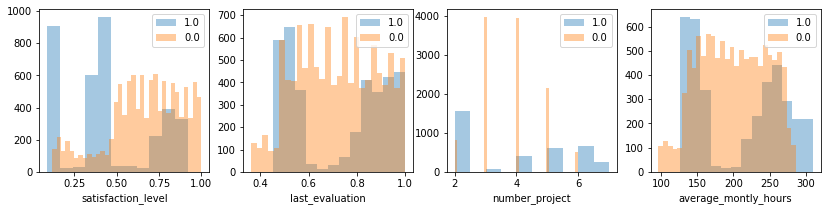

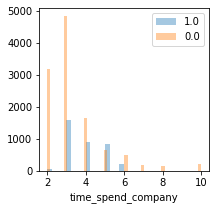

In [4]:
basicDF.plot_histogram(basicDF.numerical_features)

Dealing with outliers:

- Again analyzing the numerical variables is important to identify employess that probably look different from the others and might skew the model results. 
- Specially considering the Time Spend in the Company, there seem to be employees with extreme values.
- From now on every Feature Engineering procedure will include the outliers removal step.

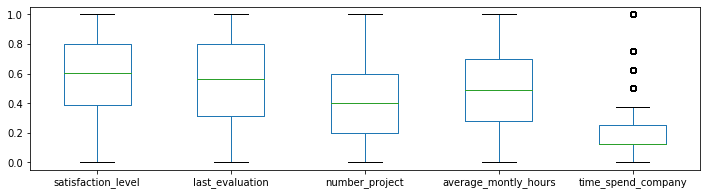

In [5]:
basicDF.scale(method='MinMaxScaler')
basicDF.numerical.plot(kind='box',figsize=(12,3))

## 2. Baseline Model

The baseline model was generated only by setting the categorical variables mentioned in the EDA process, dropping the outliers, fixing the skewness and scale of the numerical variables and dummifying all the categorical features. Then this dataset was splited and evaluated with the preivously mentioned Cross Validation function with 10 iterations. The defined validation metric is F1 Score and the result was: 0.5289

<Figure size 576x720 with 0 Axes>

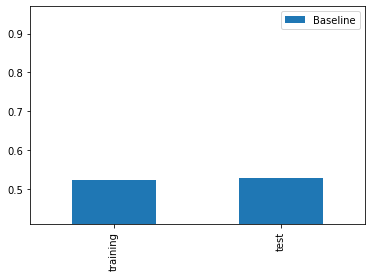

In [6]:
baseDF = basic()
baseDF.drop_samples(baseDF.outliers())
baseDF.fix_skewness()
baseDF.scale(method='MinMaxScaler')
baseDF.onehot_encode(baseDF.categorical_features)

Logit = LogisticRegression()
cv_scores, test_scores = cv_classification(baseDF, Logit, num_iterations=10)

plot_compare(classification_results,'Baseline',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['Baseline - No Outliers', np.median(cv_scores),np.median(test_scores)]

## 3.  Feature Engineering Strategies

#### A. Bucket Strategy (Original Scale Binning)

Several Binning strategies were considered for numerical variables in this step in order to tackle the non-linearity relation previously described in the EDA step:
    1. Low-Med-High Buckets: A poor result as 3 bines were not enough to differentiate clearly certain numerical features with non-linear behaviour. For instance, satisfaction level LOW considered from 0 - 0.33 covered employees with both High and Low tendency to leave the company.
    2. Several Buckets: Better result as introducing more bines allowed better differentiation. This was the final approach and all the numerical variables were discretize after removing outliers and finally one-hot encoded to proceed with the Cross Validation function.
    
- Future approach: Optimal binning libraries can improve these results.

In [7]:
def FE1():
    hrDF = dataset(Path, delimiter=',', header=0)
    hrDF.set_target('left');
    hrDF.drop_samples(hrDF.outliers())
    hrDF.discretize('satisfaction_level', [(0.0, 0.11),(0.11, 0.35),(0.35, 0.46),(0.46, 0.71),(0.71,0.92),(0.92,1.0)],category_names=['0', '1','2', '3','4','5'])
    hrDF.discretize('last_evaluation', [(0.0, 0.47),(0.47, 0.55),(0.55, 0.65),(0.65, 0.77),(0.77, 0.89),(0.89,1.0)],category_names=['0', '1','2', '3','4','5'])
    hrDF.discretize('average_montly_hours', [(0.0, 96),(96, 131),(131, 165),(165, 178),(178, 218),(218, 259),(259,287),(287,310)],category_names=['0','1','2', '3','4', '5','6','7'])
    hrDF.to_categorical(['promotion_last_5years','Work_accident','number_project','time_spend_company'])
    hrDF.onehot_encode(['satisfaction_level', 'last_evaluation','average_montly_hours','number_project','time_spend_company','salary','sales'])
    return hrDF

## 4. Model Evaluation

Many methods for feature and model selection wew evaluated:
1. Feature Engineering + Cross Validation
2. Stepwise Feature Selection (Wrapper) + CV
3. Logistic Regression Feature Importance:
        3.1. Feature Selection + CV
        3.2. Threshold Optimization + CV
4. Regularization Ridge Regression (Embedded):
        4.1. C (1/Alpha) Optimization + CV 
        4.2. Threshold Optimization + CV
        

#### 1. FE Model + CV

<Figure size 576x720 with 0 Axes>

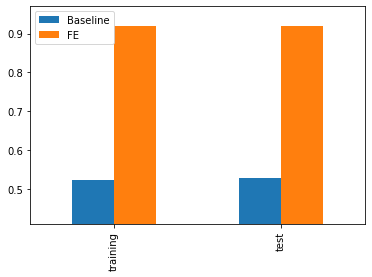

In [8]:
hrDF= FE1()

Logit = LogisticRegression()
cv_scores, test_scores = cv_classification(hrDF, Logit, num_iterations=10)

plot_compare(classification_results,'FE',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['FE', np.median(cv_scores),np.median(test_scores)]

#### 2. Wrapper Method: Stepwise Selection + CV

Considering only numerical features


<Figure size 576x720 with 0 Axes>

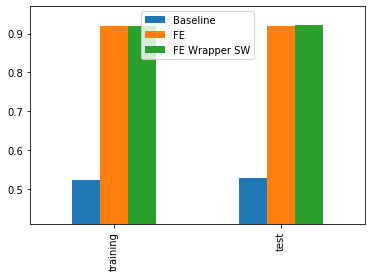

In [9]:
hrDF3 = FE1()
hrDF3.keep_columns(hrDF3.stepwise_selection())

Logit = LogisticRegression()
cv_scores, test_scores = cv_classification(hrDF3, Logit, num_iterations=10)

plot_compare(classification_results,'FE Wrapper SW',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['FE Wrapper Stepwise', np.median(cv_scores),np.median(test_scores)]

#### 3. Logistic Regression Feature Importance

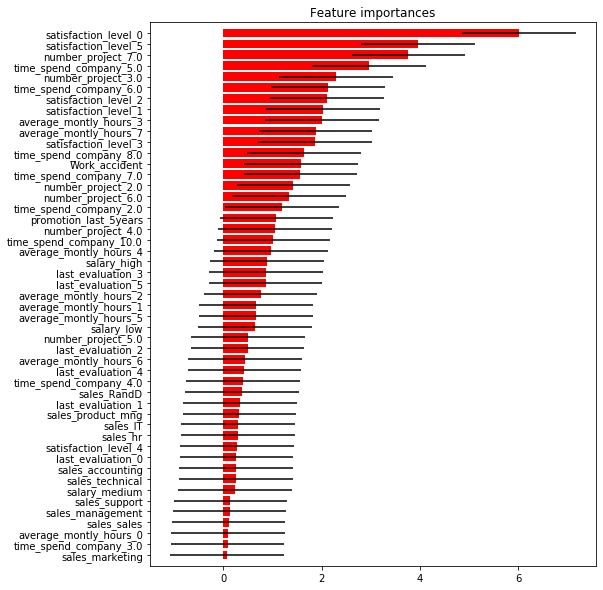

In [10]:
hrDF4 = FE1()
X, y = hrDF4.split(test_size=0.2)
Logit = LogisticRegression().fit(X.train, y.train)
plot_importance(hrDF4.features.columns, np.abs(Logit.coef_[0]))

#### 3.1. Feature Selection + CV

In [11]:
hrDF5 = FE1()
feature_list = np.arange(1, 50, 1)
metric_train = []
metric_test = []

for feature in feature_list:
    Logit = LogisticRegression()
    cv_scores, test_scores = cv_feature(hrDF5, Logit, feature, num_iterations=10)
    metric_train.append(np.median(cv_scores))
    metric_test.append(np.median(test_scores))

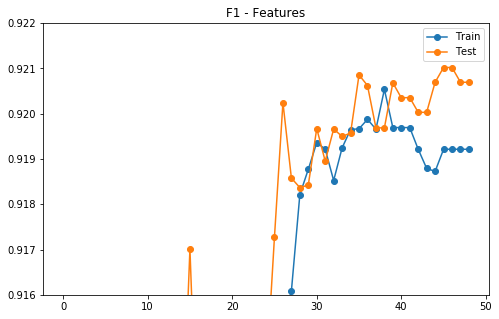

In [12]:
Scores = pd.DataFrame({'Train': metric_train, 'Test': metric_test})
plot_optimization(Scores,'F1 - Features',0.916,0.922)

In [13]:
Logit = LogisticRegression()
cv_scores, test_scores = cv_feature(hrDF5, Logit, features=46, num_iterations=10)

# plot_compare(classification_results,'FE FILR',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['FE Importance Logistic', np.median(cv_scores),np.median(test_scores)]

#### 3.2. Feature Selection + Treshold Optimization + CV

In [14]:
threshold_list = np.arange(0.05, 1.0, 0.05)
metric_train = []
metric_test = []

for threshold in threshold_list:
    cv_scores, test_scores = cv_threshold(hrDF5, Logit, features=46, threshold=threshold, num_iterations=10)
    metric_train.append(np.median(cv_scores))
    metric_test.append(np.median(test_scores))    

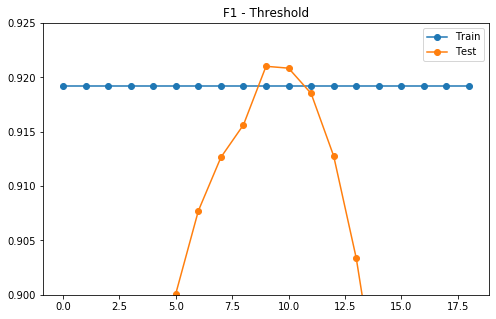

In [15]:
Scores = pd.DataFrame({'Train': metric_train, 'Test': metric_test})
plot_optimization(Scores,'F1 - Threshold',0.9,0.925)

<Figure size 576x720 with 0 Axes>

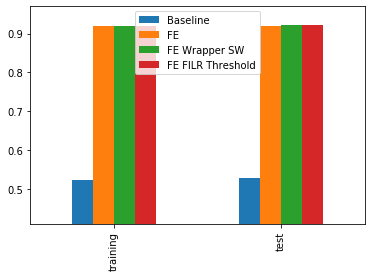

In [16]:
Logit = LogisticRegression()
cv_scores, test_scores = cv_threshold(hrDF5, Logit, features=46, threshold=0.50, num_iterations=10)

plot_compare(classification_results,'FE FILR Threshold',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['FE + FILR + Threshold', np.median(cv_scores),np.median(test_scores)]

#### 4.  Ridge Regularization

In [17]:
hrDF6 = FE1()

metric_train = []
metric_test = []

X, y = hrDF6.split(test_size=0.2)
Cs = l1_min_c(X.train, y.train, loss='log') * np.logspace(0, 7, 16)

for c in Cs:
    regularized = LogisticRegression(penalty="l2", solver='liblinear',tol=1e-6,max_iter=int(1e6),warm_start=True, intercept_scaling=10000.)
    regularized.set_params(C=c)
    
    cv_scores, test_scores = cv_regularization(hrDF6, regularized, threshold=0.5, num_iterations=10)   
    metric_train.append(np.median(cv_scores))
    metric_test.append(np.median(test_scores))

Scores = pd.DataFrame({'Train': metric_train, 'Test': metric_test})    

#### 4.1. C (1/Alpha) Optimization + CV 

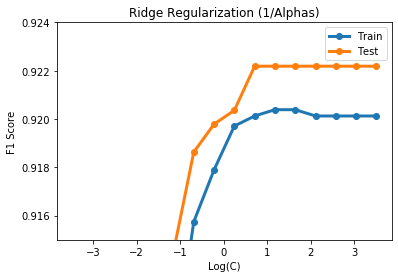

In [18]:
plot_regularization(Cs,Scores,'Ridge Regularization (1/Alphas)',0.915,0.924)

In [19]:
regularized = LogisticRegression(penalty="l2", solver='liblinear',tol=1e-6,max_iter=int(1e6),warm_start=True, intercept_scaling=10000.)
regularized.set_params(C=Cs[-7])

cv_scores, test_scores = cv_regularization(hrDF6, regularized, threshold=0.5, num_iterations=10)
#plot_compare(classification_results,'FE Ridge C Optimized',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['FE Ridge C Optimized', np.median(cv_scores),np.median(test_scores)]

#### 4.2. Threshold Optimization + CV

In [20]:
threshold_list = np.arange(0.05, 1.0, 0.05)
metric_train = []
metric_test = []

for threshold in threshold_list:
    regularized = LogisticRegression(penalty="l2", solver='liblinear',tol=1e-6,max_iter=int(1e6),warm_start=True, intercept_scaling=10000.)
    regularized.set_params(C=Cs[-7])
    
    cv_scores, test_scores = cv_regularization(hrDF6, regularized, threshold=threshold, num_iterations=10)   
    metric_train.append(np.median(cv_scores))
    metric_test.append(np.median(test_scores))
    

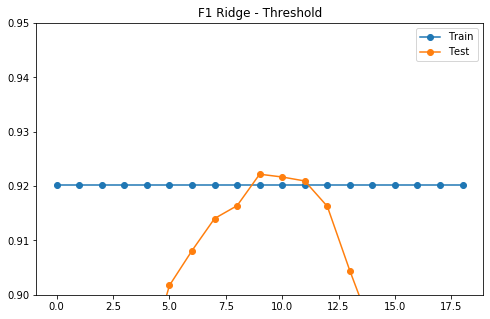

In [21]:
Scores = pd.DataFrame({'Train': metric_train, 'Test': metric_test})
plot_optimization(Scores,'F1 Ridge - Threshold',0.9,0.95)

<Figure size 576x720 with 0 Axes>

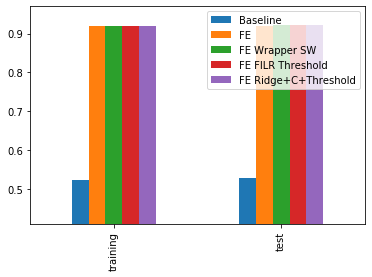

In [22]:
regularized = LogisticRegression(penalty="l2", solver='liblinear',tol=1e-6,max_iter=int(1e6),warm_start=True, intercept_scaling=10000.)
regularized.set_params(C=Cs[-7])

cv_scores, test_scores = cv_regularization(hrDF6, regularized, threshold=0.5, num_iterations=10)
plot_compare(classification_results,'FE Ridge+C+Threshold',np.median(cv_scores),np.median(test_scores))

Final_Scores.loc[len(Final_Scores)+1] = ['FE Ridge+C+Threshold', np.median(cv_scores),np.median(test_scores)]

## 5. Results and Business Interpretetation

In [23]:
Final_Scores

,Model,Train_F1,Test_F1
1,Baseline - No Outliers,0.522267,0.528912
2,FE,0.919213,0.920692
3,FE Wrapper Stepwise,0.919783,0.921650
4,FE Importance Logistic,0.919213,0.921017
5,FE + FILR + Threshold,0.919213,0.921017
6,FE Ridge C Optimized,0.920125,0.922186
7,FE Ridge+C+Threshold,0.920125,0.922186


#### Model Results
After several iterations over different feature engineering methods, I was able to outperform the baseline model with a binning strategy that allowed the model to capture non-linear relations and improve the F1 score to 0.92.

The main highlights of this process are:
1. The Ridge Regularization optimized with the best C value (1/alpha), threshold and after a cross validation process generated the best result. 
2. The input for this regularization was the result of a complete feature engineering pipeline considering a logistic regression that selected 46 features from previously binned variables and one-hot encoded.

Future approaches: 

- Different Binning strategies generated feature selection results with 30 or less variables. Based on this, it's important to keep looking to less complex models that avoid overfitting and allow better explainability. 

- This approach still has a big room for improvement, better feature creation tecniques can be applied leveraging genetic programming libraries and business knowledge.


#### Business Interpretation

The most complex business situation in this scenario is that the variables that seem to be highly correlated with employee attrition on a business context don't behave as expected. A clear example can be evidenced with the employee satisfaction level: 
    - Employees with a satisfaction level < 50% should be a clear target for HR work environment campaigns and employees with > 90% should not be considered . However, the reality presents different segements of employees with different attrition levels to be analized. 
    
I executed a complete analytic process to predict the probability of a employee leaving the company evaluated with a metric that combines 2 main factors:

    - Recall = measures the capacity of the model to capture the number of employees that left company.
    - Precission = measures the proportion of cases that the model predicted against those who really left the company.

The final output is a model that on average balance this two measures at a 92% level to predict attrition.